## Dependencies

In [2]:
# load dependencies (not all needed)
using MultivariatePolynomials,
      DynamicPolynomials,
      JuMP,
      PolyJuMP,
      SumOfSquares,
      MathOptInterfaceMosek,
      SemialgebraicSets

import IntervalArithmetic
const IA = IntervalArithmetic

# solvers
using MosekTools,
      SDPA

using Reachability: Options

<font color='red'> Now you have to run the algorithms in the Appendix. </font>

## Example 1

Compute the maximum and maximum of $x$ subject to $2x^3 - 8x + x^2 - 2 \leq 0$.

In [6]:
using Plots

The problem is unbounded to the left since the dominant term is $2x^3 \to -\infty$ when $x \to \infty$.

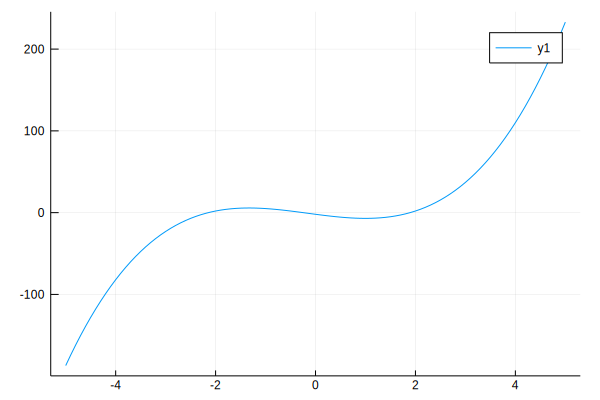

In [7]:
Plots.plot(x -> 2x^3 - 8x + x^2 - 2, -5:0.1:5)

In [8]:
@polyvar x
p = 2x^3 - 8x + x^2 - 2
opts = Options(:relaxation_degree=>5,
               :solver=>MosekTools.Mosek.Optimizer,
               :verbose=>true)

# compute the MAXIMUM of x
optimize_sublevel(p, x, opts)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 9               
  Cones                  : 1               
  Scalar variables       : 7               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

1.295463623274162e-9

However, we can get a result if we restrict to some box domain. We see from the plot that the maximum of $x$ for $x \in [-2, 2]$ and $p(x) \leq 0$ is between 1.8 and 1.9

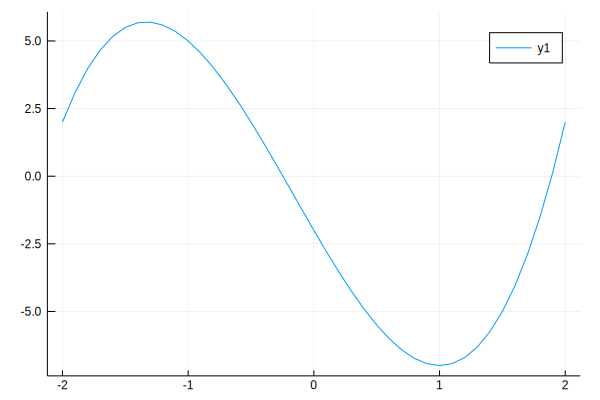

In [9]:
Plots.plot(x -> 2x^3 - 8x + x^2 - 2, -2:0.1:2)

In [10]:
@polyvar x
p = 2x^3 - 8x + x^2 - 2
opts = Options(:relaxation_degree=>5,
               :solver=>MosekTools.Mosek.Optimizer,
               :verbose=>false,
               :domain => IA.Interval(-2, 2))

# compute the MAXIMUM of x
optimize_sublevel(p, x, opts)

1.8926300741039

## Example 2

Compute the maximum of $x$ subject to $p(x, y) = x^2 + y^2 - 1 \leq 0$.

In [11]:
@polyvar x y
p = x^2 + y^2 - 1

opts = Options(:relaxation_degree=>4,
               :solver=>MosekTools.Mosek.Optimizer,
               :verbose=>false)

# compute the MAXIMUM of x
optimize_sublevel(p, x + 0*y, opts)

0.9999999923542788

The same but specifying a box domain it works as expected:

In [12]:
opts = Options(:relaxation_degree=>4,
               :solver=>MosekTools.Mosek.Optimizer,
               :verbose=>false,
               :domain => IA.IntervalBox(IA.Interval(-0.75, 0.75), 2))

# compute the MAXIMUM of x
optimize_sublevel(p, x + 0*y, opts)

0.7499999934933786

## Appendix

In [3]:
# solve model, check feasibility and return polynomials
function solve!(model, verbose=true)
    
    optimize!(model)
    
    if verbose
        println("JuMP.termination_status(model) = ", JuMP.termination_status(model))
        println("JuMP.primal_status(model) = ", JuMP.primal_status(model))
        println("JuMP.dual_status(model) = ", JuMP.dual_status(model))
        println("JuMP.objective_bound(model) = ", JuMP.objective_bound(model))
        println("JuMP.objective_value(model) = ", JuMP.objective_value(model))
    end
end

solve! (generic function with 2 methods)

In [4]:
# transform a dom (Interval or IntervalBox) into a basic semialgebraic set
function _get_box_domain(vars, dom)
    if length(vars) == 1
        # box constraints dimension one
        x = first(vars)
        B = @set IA.inf(dom) <= x && x <= IA.sup(dom)
    else
        # box constraints multidimensional case
        x = vars
        N = length(vars)
        Bi =[@set IA.inf(dom[i]) <= x[i] && x[i] <= IA.sup(dom[i]) for i in 1:N]
        B = reduce(intersect, Bi)
    end
    return B
end

_get_box_domain (generic function with 1 method)

In [5]:
# optimize the function f(x) subject to the constraint p(x) <= 0
function optimize_sublevel(p, f, opts)
    # unpack solver and options
    solver = opts[:solver]
    verbose = opts[:verbose]
    order = opts[:relaxation_degree]
    
    model = SOSModel(with_optimizer(solver, QUIET=!verbose))

    # define sub-level set of p as a basic semialgebraic set
    dom = @set p <= 0
    if :domain in keys(opts)
        B = _get_box_domain(variables(p), opts[:domain])
        dom = dom ∩ B
    end
    @variable(model, γ)
    
    # max value of f s.t. sub-level set constraint
    @constraint(model, f <= γ, domain=dom, maxdegree=order)
    @objective(model, Min, γ)

    solve!(model, verbose)
    return objective_value(model)
end

optimize_sublevel (generic function with 1 method)